Import Libraries:

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
import time
import dask.array as da
import dask.dataframe as dd
import dask
from glob import glob
import shutil

Load all images and check that their third dimensions are all 3 (for 3 color channels):

In [2]:
def preprocessing():
    cwd = os.getcwd()
    image_dir = os.path.join(cwd,'flowers')
    all_images = []

    min_x = 1000000
    min_y = 1000000

    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir,image_file)
        if os.path.isfile(image_path):
            bgr = cv2.imread(image_path)
            if bgr.shape[2] != 3:
                print("!!! Problem: ",image_path)
            else:
                if bgr.shape[0] < min_x:
                    min_x = bgr.shape[0]
                if bgr.shape[1] < min_y:
                    min_y = bgr.shape[1]
                all_images.append(image_path)
    return all_images, min_x, min_y

In [3]:
all_images, min_x, min_y = preprocessing()

In [4]:
print(f"There are {len(all_images)} images in the dataset.")
print(f"The minimum number of x pixels is {min_x}")
print(f"The minimum number of y pixels is {min_y}")

There are 733 images in the dataset.
The minimum number of x pixels is 267
The minimum number of y pixels is 336


Crop Images into same shape for simplicity:

In [5]:
def crop_images(img_list,output_folder,x_dim=min_x,y_dim=min_y):
    cropped_image_paths = []
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    for img_path in img_list:
        output_path = os.path.join(output_dir,os.path.basename(img_path))
        original_bgr = cv2.imread(img_path)
        #Crop the image:
        cropped_bgr = original_bgr[0:x_dim,0:y_dim,:]
        cv2.imwrite(output_path, cropped_bgr)
        cropped_image_paths.append(output_path)
    return cropped_image_paths

In [6]:
all_cropped_images = crop_images(all_images,'cropped',min_x, min_y)

For Loop Method:

In [7]:
def invert_with_for_loops(img_list,output_folder):
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    for img_path in img_list:
        output_path = os.path.join(output_dir,os.path.basename(img_path))
        original_bgr = cv2.imread(img_path)
        new_bgr = np.empty(original_bgr.shape)
        for i in range(original_bgr.shape[0]):
            for j in range(original_bgr.shape[1]):
                for k in range(original_bgr.shape[2]):
                    new_bgr[i,j,k] = 255 - original_bgr[i, j, k]
        cv2.imwrite(output_path, new_bgr)


In [8]:
start_time = time.time()
invert_with_for_loops(['./cropped/bougainvillea_00002.jpg'],'for_loop_test')
end_time = time.time()
duration = end_time - start_time
print(duration)

0.24526286125183105


Vectorized Method:

In [9]:
def invert_vectorized(img_list,output_folder):
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    for img_path in img_list:
        output_path = os.path.join(output_dir,os.path.basename(img_path))
        original_bgr = cv2.imread(img_path)
        new_bgr = 255 - original_bgr
        cv2.imwrite(output_path, new_bgr)

In [10]:
start_time = time.time()
invert_vectorized(['./cropped/bougainvillea_00002.jpg'],'vectorized_test')
end_time = time.time()
duration = end_time - start_time
print(duration)

0.006116390228271484


Using Dask (Vectorized and Multithreaded):

In [11]:
@dask.delayed()
def read_image(img_path):
    original_bgr = cv2.imread(img_path)
    return original_bgr

In [12]:
#https://stackoverflow.com/questions/58651143/how-do-i-save-a-dask-array-as-a-stack-of-images
def save_file(arr, output_dir, block_info=None):
    #Save file to inverted-x-y.jpg, where x and y are block locations
    for image_index in range(arr.shape[0]):
        filename = "inverted-" + "-".join(map(str, block_info[0]["chunk-location"])) + ".jpg"
        cv2.imwrite(os.path.join(output_dir,filename), arr[image_index])
    return arr

In [13]:
#https://docs.dask.org/en/latest/array-creation.html#:~:text=Dask%20delayed%20lets%20us%20delay,construct%20a%20larger%20lazy%20array.
def invert_with_dask(img_list,output_folder):
    output_dir = os.path.join(os.getcwd(),output_folder)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)

    lazy_images = [read_image(img_path) for img_path in img_list]
    sample = lazy_images[0].compute()

    arrays = [da.from_delayed(lazy_image,dtype=sample.dtype,shape=sample.shape) for lazy_image in lazy_images]
    stack = da.stack(arrays, axis=0)
    stack = 255-stack
    stack = stack.map_blocks(save_file, output_dir, dtype=stack.dtype).compute()
    

In [14]:
start_time = time.time()
invert_with_dask(['./cropped/bougainvillea_00002.jpg'],'dask_test')
end_time = time.time()
duration = end_time - start_time
print(duration)

0.01562786102294922


Time Tests For 3 Methods Across Various Qtys of Files:

In [15]:
relative_paths = []
for path in all_cropped_images:
    base_path = os.path.basename(path)
    new_path = './cropped/'+base_path
    relative_paths.append(new_path)
print(len(relative_paths))

733


In [16]:
time_tests = {}
file_qtys = [1,5,10,20,50,100,150,200,250,300,350,400,450,500,550,600,650,700,733]
for qty in file_qtys:
    print(qty)
    time_tests[qty] = {}

    img_list = relative_paths[0:qty]

    #for loop method:
    for_loop_start_time = time.time()
    invert_with_for_loops(img_list,'for_loop_'+str(qty))
    for_loop_end_time = time.time()
    for_loop_duration = for_loop_end_time - for_loop_start_time

    #vectorized method:
    vectorized_start_time = time.time()
    invert_vectorized(img_list,'vectorized_'+str(qty))
    vectorized_end_time = time.time()
    vectorized_duration = vectorized_end_time - vectorized_start_time

    #vectorized & multithreaded method:
    dask_start_time = time.time()
    invert_with_dask(img_list,'dask_'+str(qty))
    dask_end_time = time.time()
    dask_duration = dask_end_time - dask_start_time

    time_tests[qty]['for_loop'] = for_loop_duration
    time_tests[qty]['vectorized'] = vectorized_duration
    time_tests[qty]['dask'] = dask_duration


1
5
10
20
50
100
150
200
250
300
350
400
450
500
550
600
650
700
733


In [17]:
print(time_tests)

{1: {'for_loop': 0.15422940254211426, 'vectorized': 0.005516529083251953, 'dask': 0.012972593307495117}, 5: {'for_loop': 0.8781390190124512, 'vectorized': 0.049181222915649414, 'dask': 0.025864839553833008}, 10: {'for_loop': 2.036237955093384, 'vectorized': 0.022150039672851562, 'dask': 0.04740595817565918}, 20: {'for_loop': 4.347660303115845, 'vectorized': 0.05985879898071289, 'dask': 0.10387372970581055}, 50: {'for_loop': 10.533126592636108, 'vectorized': 0.1533346176147461, 'dask': 0.10035467147827148}, 100: {'for_loop': 19.732045888900757, 'vectorized': 0.27532482147216797, 'dask': 0.20652055740356445}, 150: {'for_loop': 32.12099766731262, 'vectorized': 0.3935818672180176, 'dask': 0.3507199287414551}, 200: {'for_loop': 40.07962226867676, 'vectorized': 0.5059423446655273, 'dask': 0.500708818435669}, 250: {'for_loop': 50.22118258476257, 'vectorized': 0.6841247081756592, 'dask': 0.7051045894622803}, 300: {'for_loop': 66.67925524711609, 'vectorized': 0.8052647113800049, 'dask': 0.76128

In [19]:
df = pd.DataFrame.from_dict(time_tests,orient='index')
print(df)

       for_loop  vectorized      dask
1      0.154229    0.005517  0.012973
5      0.878139    0.049181  0.025865
10     2.036238    0.022150  0.047406
20     4.347660    0.059859  0.103874
50    10.533127    0.153335  0.100355
100   19.732046    0.275325  0.206521
150   32.120998    0.393582  0.350720
200   40.079622    0.505942  0.500709
250   50.221183    0.684125  0.705105
300   66.679255    0.805265  0.761281
350   63.574834    0.935167  0.995330
400   73.427387    1.040852  1.235910
450   87.678480    1.165140  1.382918
500   90.041571    1.314079  1.520363
550  108.773852    1.435596  1.170324
600  120.881935    1.978307  1.450096
650  132.143847    1.640513  1.504231
700  146.188830    1.758737  1.830506
733  143.960273    1.873909  1.847027


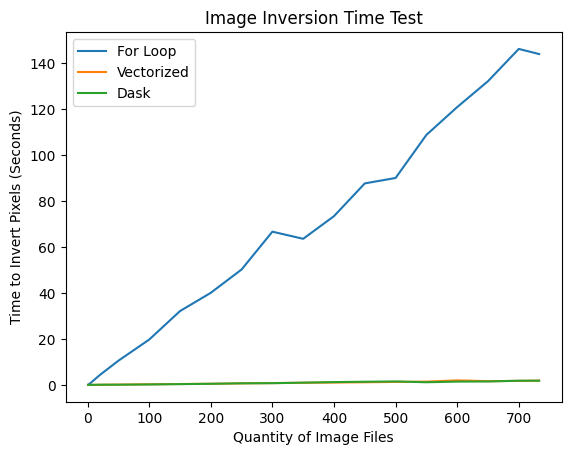

In [20]:
plt.plot(df['for_loop'],label='For Loop')
plt.plot(df['vectorized'],label='Vectorized')
plt.plot(df['dask'],label='Dask')
plt.xlabel('Quantity of Image Files')
plt.ylabel('Time to Invert Pixels (Seconds)')
plt.title('Image Inversion Time Test')
plt.legend()
plt.show()

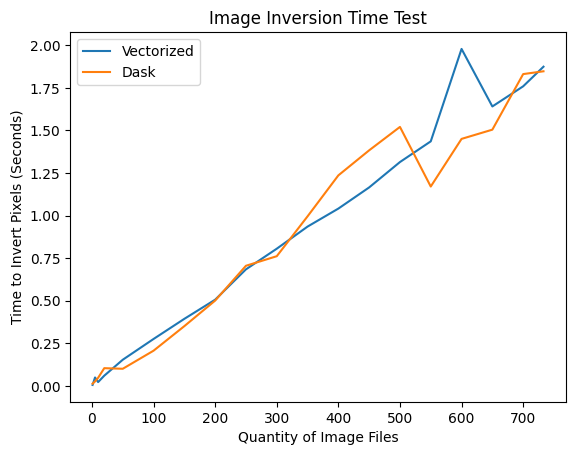

In [21]:
# plt.plot(df['for_loop'],label='For Loop')
plt.plot(df['vectorized'],label='Vectorized')
plt.plot(df['dask'],label='Dask')
plt.xlabel('Quantity of Image Files')
plt.ylabel('Time to Invert Pixels (Seconds)')
plt.title('Image Inversion Time Test')
plt.legend()
plt.show()

Let's focus only on the Dask and Vectorized Methods Now:

In [25]:
time_tests_2 = {}
file_qty_multiple = [1,2,5,10,20,50,100,200,500]
for multiple in file_qty_multiple:
    print(multiple)
    time_tests_2[qty] = {}

    img_list = relative_paths*multiple
    print(len(img_list))

    #vectorized method:
    vectorized_start_time = time.time()
    invert_vectorized(img_list,'vectorized_'+str(qty))
    vectorized_end_time = time.time()
    vectorized_duration = vectorized_end_time - vectorized_start_time

    #vectorized & multithreaded method:
    dask_start_time = time.time()
    invert_with_dask(img_list,'dask_'+str(qty))
    dask_end_time = time.time()
    dask_duration = dask_end_time - dask_start_time

    time_tests_2[qty]['vectorized'] = vectorized_duration
    time_tests_2[qty]['dask'] = dask_duration

1
733
2
1466
5
3665
10
7330
20
14660
50
36650
100
73300


MemoryError: Unable to allocate 18.4 GiB for an array with shape (73300, 267, 336, 3) and data type uint8

In [26]:
print(time_tests_2)

{733: {}}
